### 1. Data Understanding and Exploration

In [83]:
import pandas as pd

# Step 1: Load the data
#You can suppress the warning and load the data correctly like this: 
df = pd.read_csv(
    "household_power_consumption.csv",
    sep=';',   
    na_values='?',                # Treat '?' as missing
    low_memory=False              # Avoid chunked processing (helps with dtype inference)
)

# Step 2: Confirm the columns exist
print(df.columns.tolist())
# Should show: ['Date', 'Time', 'Global_active_power', ..., 'Sub_metering_3']

# Step 3: Combine 'Date' and 'Time' into 'Datetime'
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format="%d/%m/%Y %H:%M:%S", errors='coerce')

# Step 4: Now drop 'Date' and 'Time' — only AFTER combining
df.drop(columns=['Date', 'Time'], inplace=True)

#Step 5: Set index (optional but recommended)
df.set_index('Datetime', inplace=True)

#Step 6: After loading, convert the numeric columns:
cols_to_convert = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Coerce errors to NaN

# Step 6: Confirm the structure,Display basic information and the first few rows
print(df.head(2))
print(df.info())
print(df.shape)
print(df.describe)

['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   

                     Sub_metering_3  
Datetime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11

### 2. Data Preprocessing

In [85]:
#Drop "sub_metering_1" column
df.drop('Sub_metering_1', axis=1, inplace=True)

In [87]:
#Check for Missing Values
# Count missing values per column
missing_counts = df.isnull().sum()
print(missing_counts)

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [89]:
#Use linear interpolation (based on row index)
# 2. Infer object types
df.infer_objects(copy=False)

# 3. Interpolate + Fill remaining missing
#This will fill missing values by estimating values linearly between known values.
df = df.interpolate(method='linear')
df = df.bfill()
#Fill any remaining NaNs at the start or end
df = df.bfill() # backward fill for remaining missing

In [91]:
#Final check of nan values
print(df.isnull().sum())  # All values should now be 0

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


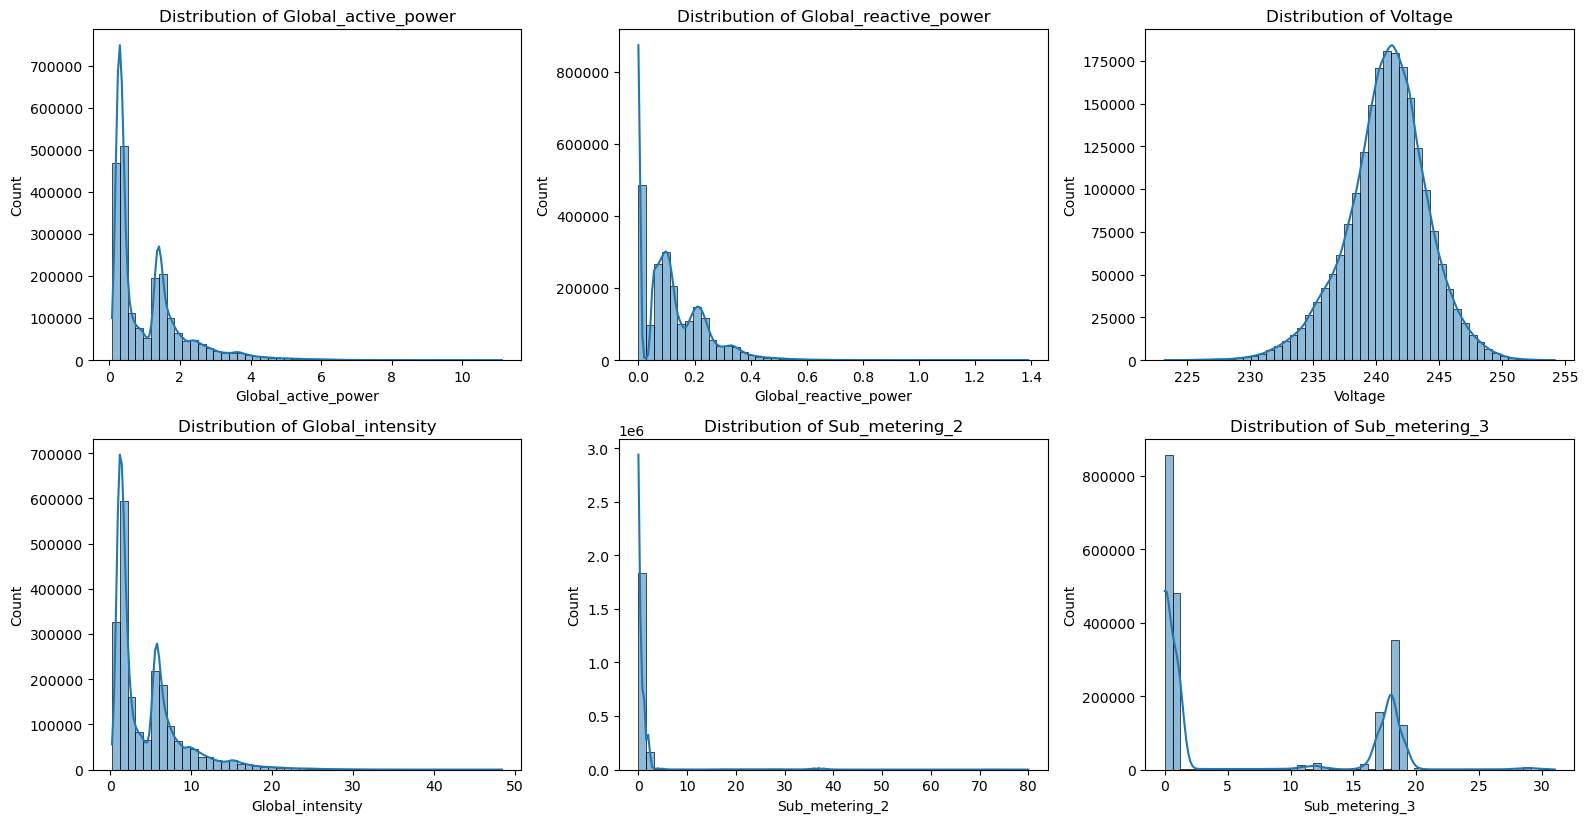

In [95]:
#Distribution Plots for Key Features
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric features to visualize
features_to_plot = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity','Sub_metering_2', 'Sub_metering_3'
]

# Plot distributions
plt.figure(figsize=(16, 12))
for i, col in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

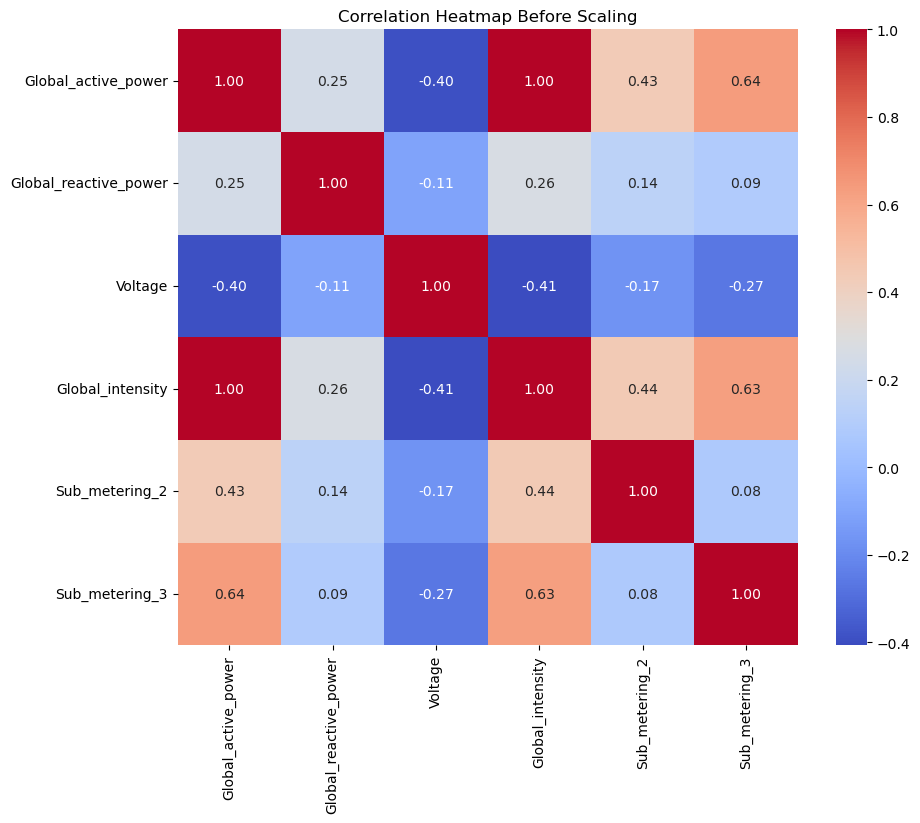

In [97]:
#Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[features_to_plot].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap Before Scaling")
plt.show()

In [99]:
# Check skewness for numeric columns
#Skewness tells you whether the data distribution is symmetric (close to 0), right-skewed (>0), or left-skewed (<0).
skew_values = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
                  'Global_intensity','Sub_metering_2', 'Sub_metering_3']].skew()

print("Skewness of numeric features:\n", skew_values)

Skewness of numeric features:
 Global_active_power      1.791581
Global_reactive_power    1.263040
Voltage                 -0.324918
Global_intensity         1.855325
Sub_metering_2           7.136054
Sub_metering_3           0.729779
dtype: float64


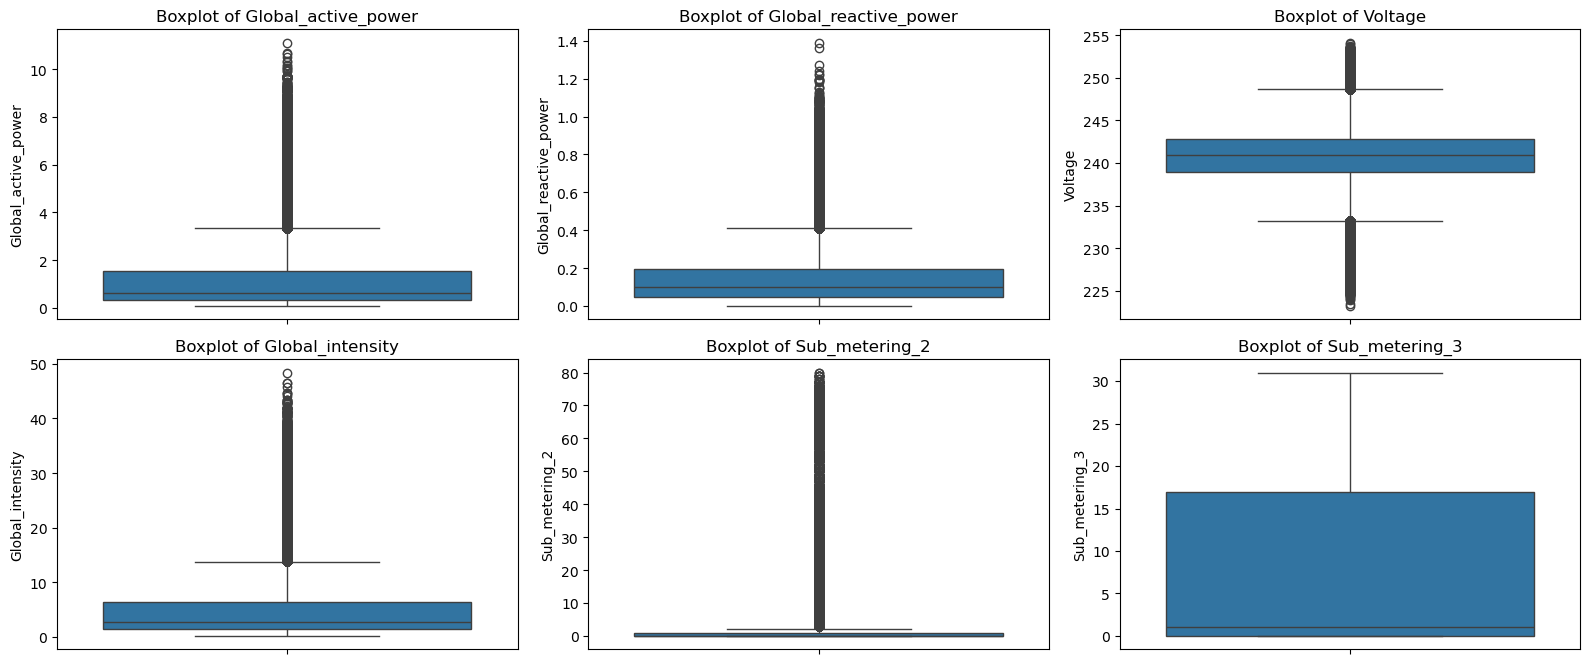

Outliers in Global_active_power: 95238 rows


In [101]:
#Detect Outliers
#Method A: Boxplot (Visual)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
for i, col in enumerate(['Global_active_power', 'Global_reactive_power', 'Voltage',
                         'Global_intensity','Sub_metering_2', 'Sub_metering_3'], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

#Method B: IQR-Based Outlier Detection (Programmatic)
# Detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[column] < Q1 - 1.5 * IQR) | (data[column] > Q3 + 1.5 * IQR)]
    return outliers

# Example for Global_active_power
outliers_gap = detect_outliers_iqr(df, 'Global_active_power')
print(f"Outliers in Global_active_power: {len(outliers_gap)} rows")

In [103]:
#Summary Output (Optional)
summary = pd.DataFrame(index=['Skewness', 'Outlier Count'])
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage',
            'Global_intensity', 'Sub_metering_2', 'Sub_metering_3']:
    outliers = detect_outliers_iqr(df, col)
    summary[col] = [df[col].skew(), len(outliers)]

print(summary.T)

                       Skewness  Outlier Count
Global_active_power    1.791581        95238.0
Global_reactive_power  1.263040        40478.0
Voltage               -0.324918        52195.0
Global_intensity       1.855325       100979.0
Sub_metering_2         7.136054        77166.0
Sub_metering_3         0.729779            0.0


In [105]:
#Handling Skewness & Outliers
#Step 1: Log transform highly skewed columns (optional but recommended)
import numpy as np
#apply log transformation to reduce skewness.
# Apply log1p to reduce skewness (log1p = log(1 + x), handles 0 safely)
skewed_cols = ['Sub_metering_2', 'Global_intensity']
for col in skewed_cols:
    df[col] = np.log1p(df[col])  # log(1 + x)

#Step 2: Apply IQR-based capping
def cap_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound,
                           np.where(df[col] > upper_bound, upper_bound, df[col]))
    return df

numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                'Global_intensity','Sub_metering_2']
df = cap_outliers_iqr(df, numeric_cols)

In [107]:
#Re-check Skewness
# Recalculate skewness
new_skew = df[[
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity','Sub_metering_2', 'Sub_metering_3'
]].skew()

print("Skewness after handling:\n", new_skew)

Skewness after handling:
 Global_active_power      1.056990
Global_reactive_power    0.827059
Voltage                 -0.187684
Global_intensity         0.387518
Sub_metering_2           1.511649
Sub_metering_3           0.729779
dtype: float64


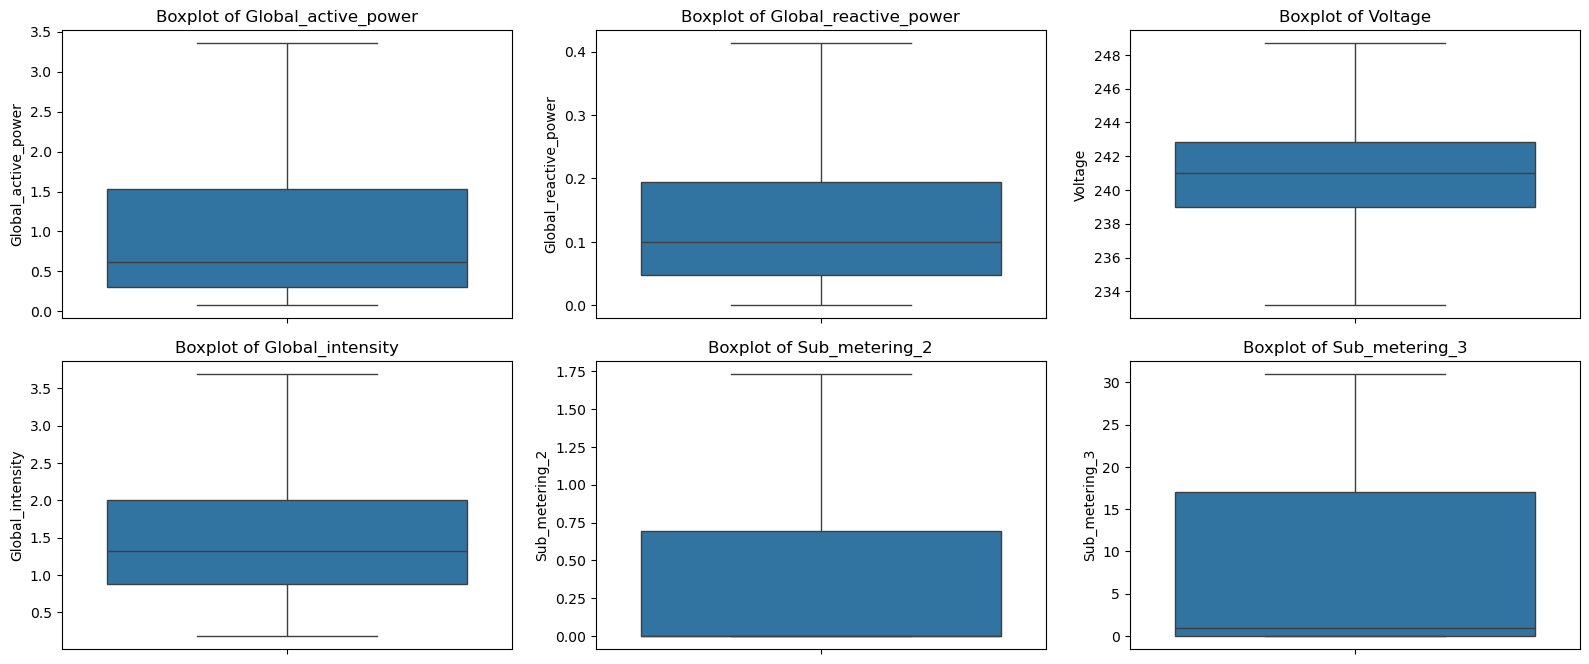

In [109]:
#Re-run Boxplots (Optional)
#Boxplots help confirm outlier capping:
plt.figure(figsize=(16, 10))
for i, col in enumerate(['Global_active_power', 'Global_reactive_power', 'Voltage',
                         'Global_intensity', 'Sub_metering_2', 'Sub_metering_3'], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [111]:
# Summary Output After Handling Skewness and Outliers
summary_post = pd.DataFrame(index=['Skewness', 'Outlier Count'])

for col in ['Global_active_power', 'Global_reactive_power', 'Voltage',
            'Global_intensity','Sub_metering_2', 'Sub_metering_3']:
    outliers = detect_outliers_iqr(df, col)  # Detect remaining outliers (should be few or zero)
    skew_val = df[col].skew()  # Recalculate skewness
    summary_post[col] = [skew_val, len(outliers)]

# Transpose for easier reading
print("\nSummary After Skewness and Outlier Handling:\n")
print(summary_post.T)


Summary After Skewness and Outlier Handling:

                       Skewness  Outlier Count
Global_active_power    1.056990            0.0
Global_reactive_power  0.827059            0.0
Voltage               -0.187684            0.0
Global_intensity       0.387518            0.0
Sub_metering_2         1.511649            0.0
Sub_metering_3         0.729779            0.0


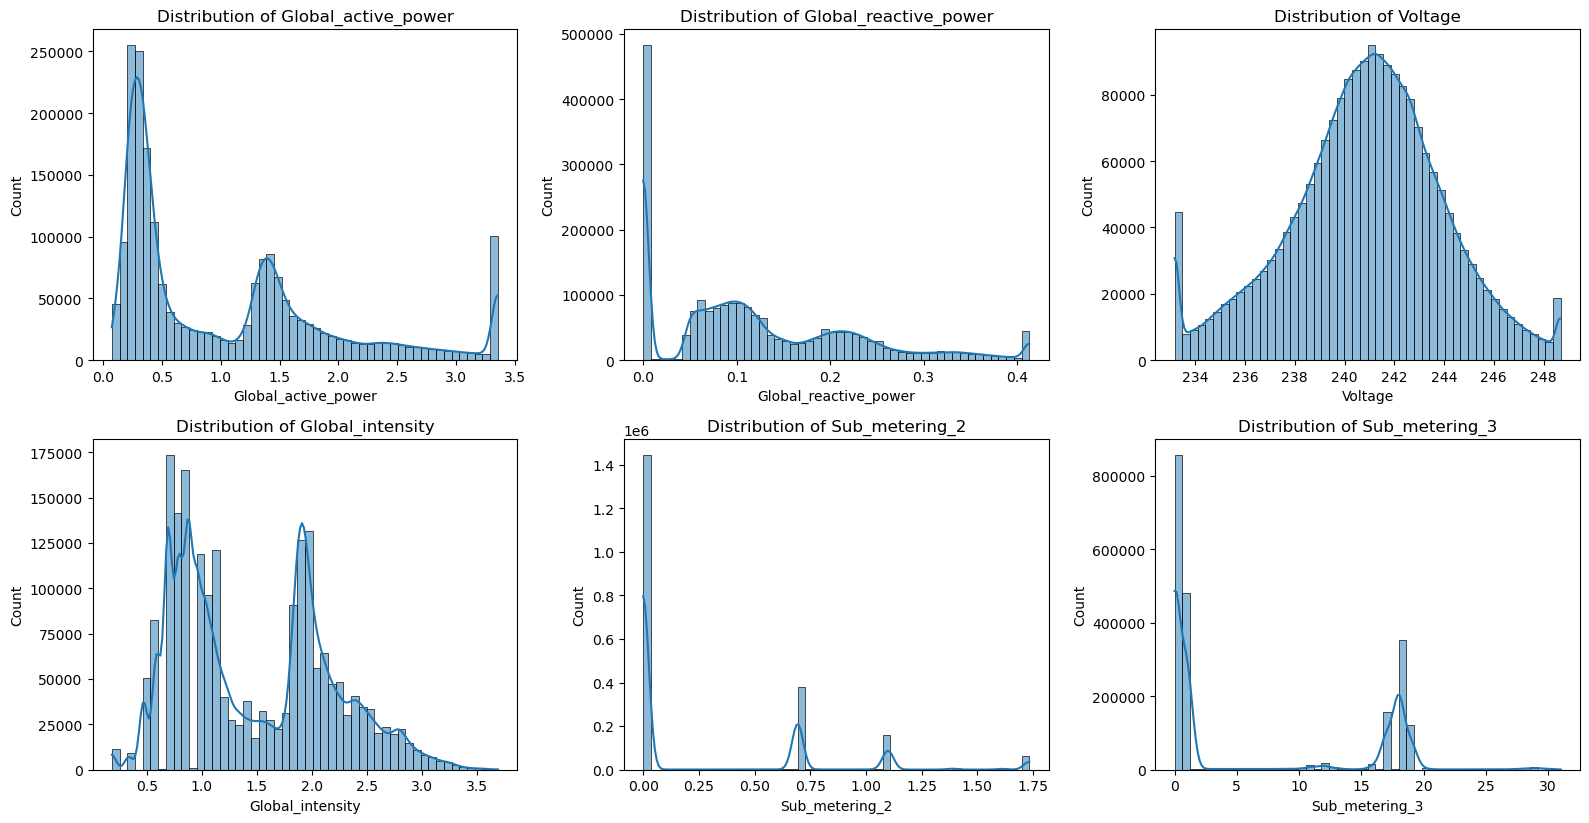

In [113]:
#Re_plot Distribution Plots for Key Features
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric features to visualize
features_to_plot = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity','Sub_metering_2', 'Sub_metering_3'
]

# Plot distributions
plt.figure(figsize=(16, 12))
for i, col in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

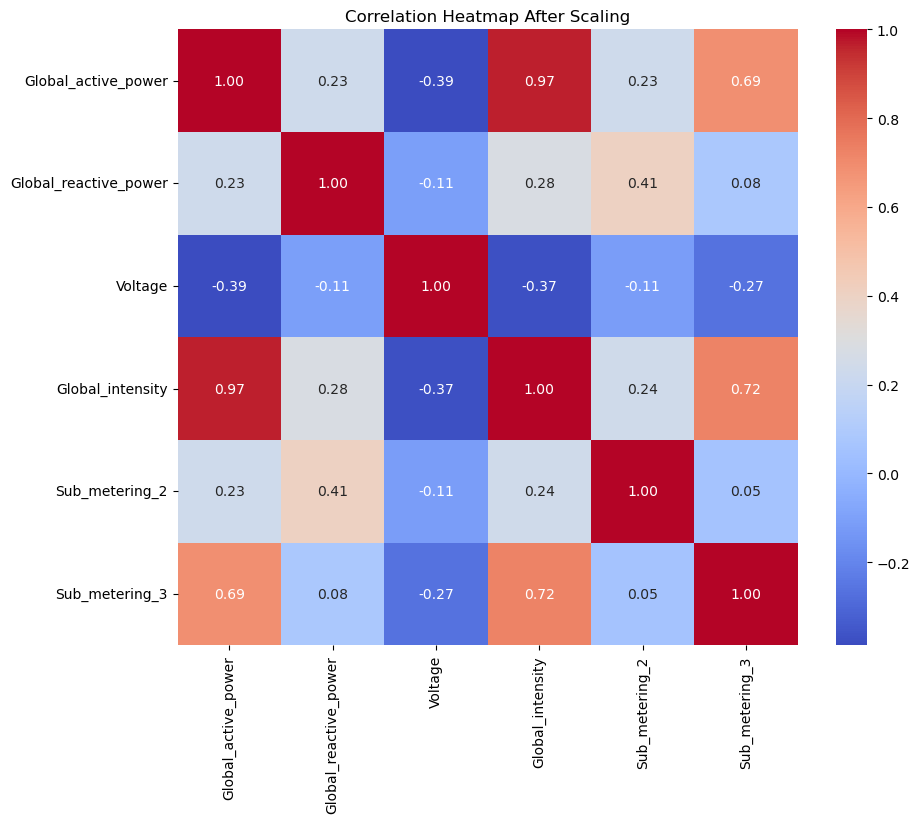

In [115]:
#Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[features_to_plot].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap After Scaling")
plt.show()

In [117]:
# Parse into separate features
# Extract individual components from the Datetime index
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Hour'] = df.index.hour
df['Minute'] = df.index.minute
df['Second'] = df.index.second

In [119]:
#Checking columns
print(df.columns)

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_3', 'Year', 'Month',
       'Day', 'Hour', 'Minute', 'Second'],
      dtype='object')


In [121]:
df.shape

(2075259, 12)

In [123]:
#Daily Averages
#Group by day and calculate mean of energy metrics:
df['Daily_Avg_Global_active_power'] = df['Global_active_power'].resample('D').transform('mean')

#Peak Hour Indicator
#Define a peak usage window (e.g., 6–9 AM and 5–9 PM):
df['Hour'] = df.index.hour
df['Is_Peak_Hour'] = df['Hour'].apply(lambda x: 1 if (6 <= x <= 9) or (17 <= x <= 21) else 0)

#Rolling Averages
#Smooth out short-term fluctuations:
# 1-hour rolling average (assuming data is minutely)
df['Rolling_1H_Global_active_power'] = df['Global_active_power'].rolling(window=60).mean()

# 1-day rolling average
df['Rolling_1D_Global_active_power'] = df['Global_active_power'].rolling(window=1440).mean()

#⚠️ 1440 = 24 hours × 60 minutes if your data is at 1-minute intervals

#Final Check
print(df[['Global_active_power', 'Daily_Avg_Global_active_power', 'Is_Peak_Hour', 'Rolling_1H_Global_active_power']].head(10))

                     Global_active_power  Daily_Avg_Global_active_power  \
Datetime                                                                  
2006-12-16 17:24:00                3.355                       2.851417   
2006-12-16 17:25:00                3.355                       2.851417   
2006-12-16 17:26:00                3.355                       2.851417   
2006-12-16 17:27:00                3.355                       2.851417   
2006-12-16 17:28:00                3.355                       2.851417   
2006-12-16 17:29:00                3.355                       2.851417   
2006-12-16 17:30:00                3.355                       2.851417   
2006-12-16 17:31:00                3.355                       2.851417   
2006-12-16 17:32:00                3.355                       2.851417   
2006-12-16 17:33:00                3.355                       2.851417   

                     Is_Peak_Hour  Rolling_1H_Global_active_power  
Datetime                       

In [125]:
#Why NaN?,You're using: df['Global_active_power'].rolling(window=60).mean()
#This means it needs 60 rows before it can compute the first rolling mean.
#Your example only shows the first 10 rows — so it's still accumulating data.
#Scroll or print more rows (after the 60th row) and you'll see the values appear.
#Try this:
df[['Global_active_power', 'Rolling_1H_Global_active_power']].iloc[60:70]

,Global_active_power,Rolling_1H_Global_active_power
Datetime,,
2006-12-16 18:24:00,3.355,3.210467
2006-12-16 18:25:00,3.355,3.210467
2006-12-16 18:26:00,3.355,3.210467
2006-12-16 18:27:00,3.355,3.210467
2006-12-16 18:28:00,3.176,3.207483
2006-12-16 18:29:00,2.920,3.200233
2006-12-16 18:30:00,2.930,3.193150
2006-12-16 18:31:00,2.912,3.185767
2006-12-16 18:32:00,2.608,3.173317


In [127]:
# Standardization:
# Z-Score Standardization (StandardScaler)
from sklearn.preprocessing import StandardScaler

# Select numeric columns to scale
numeric_cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity','Sub_metering_2', 'Sub_metering_3'
]

# Initialize and apply scaler
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df[numeric_cols])

# Create a new DataFrame with scaled values
df_scaled = pd.DataFrame(scaled_array, columns=numeric_cols, index=df.index)

# Optional: add back other non-scaled columns (like engineered features)
df_scaled = pd.concat([df_scaled, df.drop(columns=numeric_cols)], axis=1)

In [129]:
#TO view the scaled data
print(df_scaled.head())

                     Global_active_power  Global_reactive_power   Voltage  \
Datetime                                                                    
2006-12-16 17:24:00             2.530536               2.750373 -1.918785   
2006-12-16 17:25:00             2.530536               2.750373 -2.304774   
2006-12-16 17:26:00             2.530536               2.750373 -2.413234   
2006-12-16 17:27:00             2.530536               2.750373 -2.269684   
2006-12-16 17:28:00             2.530536               2.750373 -1.650825   

                     Global_intensity  Sub_metering_2  Sub_metering_3  Year  \
Datetime                                                                      
2006-12-16 17:24:00          2.138890        0.903119        1.254491  2006   
2006-12-16 17:25:00          2.443448        0.903119        1.135667  2006   
2006-12-16 17:26:00          2.443448        1.782975        1.254491  2006   
2006-12-16 17:27:00          2.443448        0.903119        1.25

In [131]:
#Check Summary Statistics
#After scaling, the mean should be ~0 and the standard deviation ~1 for each scaled column:
print(df_scaled[numeric_cols].describe())

       Global_active_power  Global_reactive_power       Voltage  \
count         2.075259e+06           2.075259e+06  2.075259e+06   
mean         -4.840537e-16           6.413877e-16  2.403631e-14   
std           1.000000e+00           1.000000e+00  1.000000e+00   
min          -1.064557e+00          -1.150393e+00 -2.451514e+00   
25%          -8.079999e-01          -6.970352e-01 -5.949368e-01   
50%          -4.746945e-01          -2.058976e-01  4.625209e-02   
75%           5.274145e-01           6.819281e-01  6.427811e-01   
max           2.530536e+00           2.750373e+00  2.499358e+00   

       Global_intensity  Sub_metering_2  Sub_metering_3  
count      2.075259e+06    2.075259e+06    2.075259e+06  
mean      -9.748457e-16    1.141657e-16   -3.722437e-17  
std        1.000000e+00    1.000000e+00    1.000000e+00  
min       -1.844422e+00   -6.010042e-01   -7.655055e-01  
25%       -8.523021e-01   -6.010042e-01   -7.655055e-01  
50%       -2.129150e-01   -6.010042e-01   -6.466

## 3. Feature Engineering:

In [133]:
# Feature Engineering Section

# 1. Day of the week (0=Monday, 6=Sunday)
df['DayOfWeek'] = df.index.dayofweek

# 2. Weekend indicator
df['Is_Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# 3. Lag features (shifted versions of the target)
df['Lag_1'] = df['Global_active_power'].shift(1)
df['Lag_2'] = df['Global_active_power'].shift(2)

# 4. Total sub-metering
df['Sub_metering_total'] = (df['Sub_metering_2'] + df['Sub_metering_3'])

# 5. Power to intensity ratio
df['Power_to_Intensity'] = df['Global_active_power'] / (df['Global_intensity'] + 1e-5)

# 6. Drop rows with NaNs caused by lag/rolling
df.dropna(inplace=True)

# Confirm new features added
print(df[['DayOfWeek', 'Is_Weekend', 'Lag_1', 'Lag_2', 'Sub_metering_total', 'Power_to_Intensity']].head(2))

                     DayOfWeek  Is_Weekend  Lag_1  Lag_2  Sub_metering_total  \
Datetime                                                                       
2006-12-17 17:23:00          6           1  3.130  3.355                16.0   
2006-12-17 17:24:00          6           1  3.238  3.130                17.0   

                     Power_to_Intensity  
Datetime                                 
2006-12-17 17:23:00            1.201646  
2006-12-17 17:24:00            1.221207  


In [135]:
# Feature Summary for Modeling
features = [
    'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_2', 'Sub_metering_3','Hour', 'Day', 
    'Month', 'DayOfWeek', 'Is_Weekend', 'Is_Peak_Hour',
    'Rolling_1H_Global_active_power', 'Rolling_1D_Global_active_power',
    'Lag_1', 'Lag_2', 'Sub_metering_total', 'Power_to_Intensity'
]

X = df[features]
y = df['Global_active_power']

In [137]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_3', 'Year', 'Month',
       'Day', 'Hour', 'Minute', 'Second', 'Daily_Avg_Global_active_power',
       'Is_Peak_Hour', 'Rolling_1H_Global_active_power',
       'Rolling_1D_Global_active_power', 'DayOfWeek', 'Is_Weekend', 'Lag_1',
       'Lag_2', 'Sub_metering_total', 'Power_to_Intensity'],
      dtype='object')

In [139]:
#Scale Features for ML Models
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 4. Model Selection and Training:

In [141]:
# Model Selection and Training (Train/Test Split)

from sklearn.model_selection import train_test_split

# Define your target and features
target = 'Global_active_power'
features = df.drop(columns=[target])

# Ensure target column is present
X = features
y = df[target]

# Split the dataset (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (1451674, 21)
Testing set size: (622146, 21)


## 5. Model Evaluation:

In [143]:
# Linear Regression – Hyperparameter Tuning
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# Hyperparameter tuning
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Best model
best_ridge = ridge_grid.best_estimator_
ridge_pred = best_ridge.predict(X_test)

# Evaluation
ridge_rmse = root_mean_squared_error(y_test, ridge_pred)
ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

print("Ridge Regression Results (Tuned Linear Regression):")
print(f" - Best Alpha: {ridge_grid.best_params_['alpha']}")
print(f" - RMSE: {ridge_rmse:.4f}")
print(f" - MAE : {ridge_mae:.4f}")
print(f" - R²  : {ridge_r2:.4f}")

Ridge Regression Results (Tuned Linear Regression):
 - Best Alpha: 0.01
 - RMSE: 0.1110
 - MAE : 0.0769
 - R²  : 0.9852


In [147]:
# Random Forest – Hyperparameter Tuning(with sample subset)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# Sample a smaller subset of training data
X_train_small = X_train.sample(frac=0.3, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

# Hyperparameter tuning (reduced options for speed)
rf_params = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2]
}

# Use fewer cross-validation folds
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=2,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
rf_grid.fit(X_train_small, y_train_small)

# Best model
best_rf = rf_grid.best_estimator_
rf_pred = best_rf.predict(X_test)

# Evaluation
rf_rmse = root_mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest Results:")
print(f" - Best Params: {rf_grid.best_params_}")
print(f" - RMSE: {rf_rmse:.4f}")
print(f" - MAE : {rf_mae:.4f}")
print(f" - R²  : {rf_r2:.4f}")

Random Forest Results:
 - Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
 - RMSE: 0.0015
 - MAE : 0.0001
 - R²  : 1.0000


In [149]:
# Gradient Boosting– Hyperparameter Tuning (with sample subset)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Use a smaller sample
X_train_small = X_train.sample(frac=0.3, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

# Define fewer hyperparameters for speed
gb_params = {
    'n_estimators': [100],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5]
}

# Grid Search
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_params,
    cv=2,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
gb_grid.fit(X_train_small, y_train_small)

# Best model
best_gb = gb_grid.best_estimator_
gb_pred = best_gb.predict(X_test)

# Evaluation
gb_rmse = root_mean_squared_error(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

print("Gradient Boosting Results:")
print(f" - Best Params: {gb_grid.best_params_}")
print(f" - RMSE: {gb_rmse:.4f}")
print(f" - MAE : {gb_mae:.4f}")
print(f" - R²  : {gb_r2:.4f}")

Gradient Boosting Results:
 - Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
 - RMSE: 0.0041
 - MAE : 0.0024
 - R²  : 1.0000


In [151]:
# Neural Network (MLP Regressor) -Hyperparameter Tuning (with sample subset)
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Use the same smaller sample
X_train_small = X_train.sample(frac=0.3, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

# Reduce number of options to speed up tuning
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'max_iter': [200]
}

# Grid Search
mlp_grid = GridSearchCV(
    MLPRegressor(random_state=42),
    mlp_params,
    cv=2,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
mlp_grid.fit(X_train_small, y_train_small)

# Best model
best_mlp = mlp_grid.best_estimator_
mlp_pred = best_mlp.predict(X_test)

# Evaluation
mlp_rmse = root_mean_squared_error(y_test, mlp_pred)
mlp_mae = mean_absolute_error(y_test, mlp_pred)
mlp_r2 = r2_score(y_test, mlp_pred)

print("Neural Network (MLP) Results:")
print(f" - Best Params: {mlp_grid.best_params_}")
print(f" - RMSE: {mlp_rmse:.4f}")
print(f" - MAE : {mlp_mae:.4f}")
print(f" - R²  : {mlp_r2:.4f}")

Neural Network (MLP) Results:
 - Best Params: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'max_iter': 200, 'solver': 'adam'}
 - RMSE: 1.2660
 - MAE : 1.2604
 - R²  : -0.9290
